# Goal

The goal is to create a model for classifying newswires into topics. The data used for creating the model was published by Reuters in 1986. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

As with the IMDB dataset, the argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


In [2]:
len(train_data), len(test_data)

(8982, 2246)

In [3]:
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [4]:
len(np.unique(train_labels))

46

## Decoding the data

In [5]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])  
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

## Preparing the data

In [6]:
# one hot encoding of input features and labels

def one_hot_encode(sequences: np.array, dim: int = 10000) -> np.array:
    ret = np.zeros((sequences.shape[0], dim))
    for i, s in enumerate(sequences):
        ret[i, s] = 1 
    return ret

In [7]:
x_train = one_hot_encode(train_data)
x_test = one_hot_encode(test_data)

In [8]:
x_train.shape, x_test.shape

((8982, 10000), (2246, 10000))

In [9]:
y_train = one_hot_encode(train_labels, dim = 46)
y_test = one_hot_encode(test_labels, dim = 46)

In [10]:
y_train.shape, y_test.shape

((8982, 46), (2246, 46))

## Network Architecture

### Model 1

In [11]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

## Loss Function 

The loss function used in multiclass classification is categorical cross-entropy. Assume that the class labels have been one-hot encoded as in our case. Let the number of class labels be $C$. Given an example $(\mathbf{x}, \mathbf{t} = \{ t_i \}_{i = 1}^{C})$, suppose $\mathbf{s} = \{ s_i \}_{i = 1}^C$ is the predicted output. The cross-entropy loss is defined as:
$$
    \text{Loss} = - \sum_{i = 1}^{C} t_i \log (s_i).
$$

In our case, we use softmax as the activation function in the final layer. Using $s_i$ to denote the weighted output of the $i$th node in the final layer _before_ the application of the activation function, the cross-entropy loss can be written as:
$$
    \text{Loss} = - \sum_{i = 1}^{C} t_i \log \left ( \frac{e^{s_i}}{\sum_{j = 1}^C e^{s_j}} \right ).
$$

Since we assumed the labels to be one-hot encoded, there exists $1 \leq p \leq C$ such that $t_i = 1$ iff $i = p$. Thus all terms except the $p$th drop out from the right and the expression simplifies to:
$$
    \text{Loss} = - \log \left ( \frac{e^{s_p}}{\sum_{j = 1}^C e^{s_j}} \right ).
$$

In [12]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Set Aside Validation Set

In [13]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 182us/step - loss: 2.7107 - accuracy: 0.5210 - val_loss: 1.8002 - val_accuracy: 0.6260
Epoch 2/20
7982/7982 [==============================] - 1s 99us/step - loss: 1.4629 - accuracy: 0.7068 - val_loss: 1.3388 - val_accuracy: 0.7070
Epoch 3/20
7982/7982 [==============================] - 1s 116us/step - loss: 1.0738 - accuracy: 0.7754 - val_loss: 1.1241 - val_accuracy: 0.7700
Epoch 4/20
7982/7982 [==============================] - 1s 104us/step - loss: 0.8505 - accuracy: 0.8240 - val_loss: 1.0311 - val_accuracy: 0.7790
Epoch 5/20
7982/7982 [==============================] - 1s 113us/step - loss: 0.6843 - accuracy: 0.8587 - val_loss: 0.9666 - val_accuracy: 0.7960
Epoch 6/20
7982/7982 [==============================] - 1s 115us/step - loss: 0.5557 - accuracy: 0.8827 - val_loss: 0.9200 - val_accuracy: 0.8080
Epoch 7/20
7982/7982 [==============================] - 1s 111us/step - loss:

## Training and Validation Loss and Accuracy

In [15]:
import matplotlib.pyplot as plt
import keras

def train_val_loss(history: keras.models.Sequential.fit):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
    
def train_val_acc(history: keras.models.Sequential.fit):
    history_dict = history.history
    
    plt.clf()  
    try:
        acc = history_dict['acc'] 
        val_acc = history_dict['val_acc']
    except: 
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy'] 
    
    epochs = range(1, len(val_acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

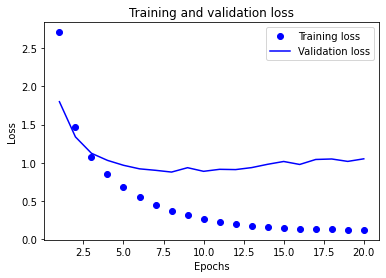

In [16]:
train_val_loss(history)

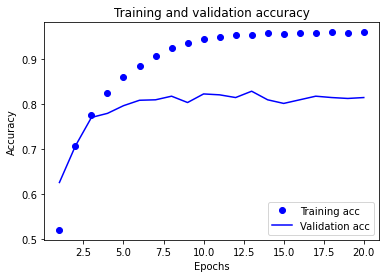

In [17]:
train_val_acc(history)

The model begins to overfit after about 7 epochs. We therefore train a new model with seven epochs. 

### Model 2

In [18]:
model2 = models.Sequential()
model2.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(46, activation='softmax'))

model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model2.fit(partial_x_train,
           partial_y_train,
           epochs=7,
           batch_size=512,
           validation_data=(x_val, y_val))

results = model2.evaluate(x_test, y_test)

results

Train on 7982 samples, validate on 1000 samples
Epoch 1/7
7982/7982 [==============================] - 1s 164us/step - loss: 2.5947 - accuracy: 0.5237 - val_loss: 1.7233 - val_accuracy: 0.6340
Epoch 2/7
7982/7982 [==============================] - 1s 99us/step - loss: 1.4135 - accuracy: 0.7013 - val_loss: 1.3070 - val_accuracy: 0.7200
Epoch 3/7
7982/7982 [==============================] - 1s 111us/step - loss: 1.0351 - accuracy: 0.7760 - val_loss: 1.1519 - val_accuracy: 0.7340
Epoch 4/7
7982/7982 [==============================] - 1s 117us/step - loss: 0.8081 - accuracy: 0.8302 - val_loss: 1.0690 - val_accuracy: 0.7630
Epoch 5/7
7982/7982 [==============================] - 1s 114us/step - loss: 0.6440 - accuracy: 0.8652 - val_loss: 0.9650 - val_accuracy: 0.8010
Epoch 6/7
7982/7982 [==============================] - 1s 116us/step - loss: 0.5099 - accuracy: 0.8981 - val_loss: 0.9379 - val_accuracy: 0.7960
Epoch 7/7
2246/2246 [==============================] - 2s 949us/step


[0.9977224242549227, 0.7760462760925293]

## Accuracy of a Random Classifier 

The accuracy of the model2 on test data is 78%. How good is that? If we randomly classified the labels in the test data, how badly would we fare?

In [19]:
print(sorted(np.unique(test_labels)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]


In [20]:
len(test_labels)

2246

In [21]:
random_classifier = np.random.randint(low=0, high=46, size=2246)
random_classifier.shape

(2246,)

In [22]:
print(sorted(np.unique(random_classifier)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]


In [23]:
correct_labels = (random_classifier == test_labels)

float(sum(correct_labels) / len(test_labels))

0.017809439002671415

Thus with a random classifier, we would expect an accuracy of around 2%. Model2 achieves an accuracy of around 78%. Thus with a random classifier as baseline, our model performs pretty good.

### Predictions of Model 2

In [24]:
predict = model2.predict(x_test)

predict[0]

array([9.1115951e-05, 3.6861666e-04, 1.7890852e-04, 9.6986043e-01,
       2.1313550e-02, 4.6084075e-05, 8.7945744e-05, 1.5910302e-05,
       9.4202039e-04, 7.0198980e-06, 9.0769638e-05, 9.8507188e-04,
       4.1258408e-04, 4.2396251e-04, 8.3108898e-05, 4.4706572e-05,
       1.1181824e-03, 1.5306710e-04, 1.2526853e-04, 4.7963561e-04,
       8.8021968e-04, 2.4665275e-04, 1.4502822e-05, 8.6790606e-05,
       3.5229608e-05, 2.1678506e-04, 8.4797512e-06, 1.8058265e-05,
       5.1675906e-04, 2.0657662e-04, 5.0067501e-05, 2.2150807e-05,
       2.5604897e-05, 3.0780840e-05, 2.2262530e-04, 9.7149195e-06,
       1.6006331e-04, 6.8641493e-05, 4.9829882e-06, 1.9316985e-04,
       7.0612354e-05, 1.3767093e-05, 2.9908535e-05, 2.7015883e-05,
       1.8540344e-06, 1.1047612e-05], dtype=float32)

In [25]:
sum(predict[0])

1.0000000249141294

In [26]:
np.argmax(predict[0])

3

## Model 3

In [27]:
model3 = models.Sequential()
model3.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(46, activation='softmax'))

model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model3.fit(partial_x_train,
           partial_y_train,
           epochs=6,
           batch_size=512,
           validation_data=(x_val, y_val))

results = model3.evaluate(x_test, y_test)

results

Train on 7982 samples, validate on 1000 samples
Epoch 1/6
7982/7982 [==============================] - 2s 196us/step - loss: 2.1206 - accuracy: 0.5759 - val_loss: 1.3441 - val_accuracy: 0.7020
Epoch 2/6
7982/7982 [==============================] - 1s 142us/step - loss: 1.0835 - accuracy: 0.7655 - val_loss: 1.1489 - val_accuracy: 0.7350
Epoch 3/6
7982/7982 [==============================] - 1s 152us/step - loss: 0.7710 - accuracy: 0.8330 - val_loss: 1.0306 - val_accuracy: 0.7510
Epoch 4/6
7982/7982 [==============================] - 1s 139us/step - loss: 0.5565 - accuracy: 0.8804 - val_loss: 0.8926 - val_accuracy: 0.8140
Epoch 5/6
7982/7982 [==============================] - 1s 149us/step - loss: 0.4166 - accuracy: 0.9108 - val_loss: 0.9027 - val_accuracy: 0.8020
Epoch 6/6
2246/2246 [==============================] - 1s 440us/step


[0.9550841410884024, 0.7934104800224304]

## Model 4

In [28]:
model4 = models.Sequential()
model4.add(layers.Dense(150, activation='relu', input_shape=(10000,)))
model4.add(layers.Dense(150, activation='relu'))
model4.add(layers.Dense(46, activation='softmax'))

model4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model4.fit(partial_x_train,
           partial_y_train,
           epochs=4,
           batch_size=512,
           validation_data=(x_val, y_val))

results = model4.evaluate(x_test, y_test)

results

Train on 7982 samples, validate on 1000 samples
Epoch 1/4
7982/7982 [==============================] - 1s 186us/step - loss: 2.1104 - accuracy: 0.5631 - val_loss: 1.3455 - val_accuracy: 0.7000
Epoch 2/4
7982/7982 [==============================] - 1s 153us/step - loss: 1.0864 - accuracy: 0.7625 - val_loss: 1.0790 - val_accuracy: 0.7630
Epoch 3/4
7982/7982 [==============================] - 1s 159us/step - loss: 0.7450 - accuracy: 0.8410 - val_loss: 0.9955 - val_accuracy: 0.7780
Epoch 4/4
2246/2246 [==============================] - 1s 486us/step


[0.9672809761757312, 0.780053436756134]